Predict script for Split model, predict the D and R matrices, and visualize the result.

In [13]:
import os
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel
import json
from PIL import Image
import torch
# from torchsummary import summary
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from data_utils.utils import refine_split_results

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [21]:
# load dataset
IMG_DIR = '/Users/longhoang/Developer/table-recognition/data/SciTSR-partition/val/img'
LABEL = '/Users/longhoang/Developer/table-recognition/data/SciTSR-partition/val/label/split_label.json'

with open(LABEL, 'r') as f:
    labels = json.load(f)
    
dataset = ImageDataset(IMG_DIR, labels, 8, scale=1, returns_image_name=True)

In [22]:
# init model
CP_PATH = '/Users/longhoang/Developer/table-recognition/pret-models/split0.pth'
net = SplitModel(3)

if torch.cuda.is_available():
    net = torch.nn.DataParallel(net).cuda()
    net.load_state_dict(torch.load(CP_PATH))
else:
    net = torch.nn.DataParallel(net)
    net.load_state_dict(torch.load(CP_PATH, map_location=torch.device('cpu')))

In [23]:
# change to eval mode
net.eval()

DataParallel(
  (module): SplitModel(
    (sfcn): SFCN(
      (conv1): Sequential(
        (0): Conv2d(3, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(18, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(18, 18, kernel_size=(7, 7), stride=(1, 1), padding=(6, 6), dilation=(2, 2), bias=False)
        (1): ReLU(inplace=True)
      )
    )
    (rpn1): ProjectionNet(
      (conv_branch1): Sequential(
        (0): Conv2d(18, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): GroupNorm(3, 6, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (conv_branch2): Sequential(
        (0): Conv2d(18, 6, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
        (1): GroupNorm(3, 6, eps=1e-05, affine=True)
        (2): ReLU

In [24]:
img, label, name = dataset[50]
r,c = net(img.unsqueeze(0))
r = r[-1]>0.5
c = c[-1]>0.5
c = c.cpu().detach().numpy()
r = r.cpu().detach().numpy()

r = refine_split_results(r)
c = refine_split_results(c)

r_im = r.reshape((-1,1)) * np.ones((r.shape[0],c.shape[0]))
c_im = c.reshape((1,-1)) * np.ones((r.shape[0],c.shape[0]))
im = cv2.bitwise_or(r_im,c_im)

In [25]:
name

'0810.2598v2.2'

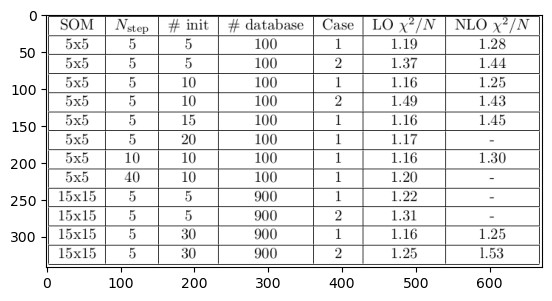

In [15]:
plt.imshow(img.numpy().transpose(1,2,0))

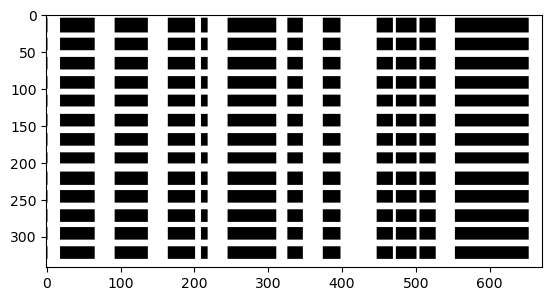

In [16]:
plt.imshow(im, cmap='gray')

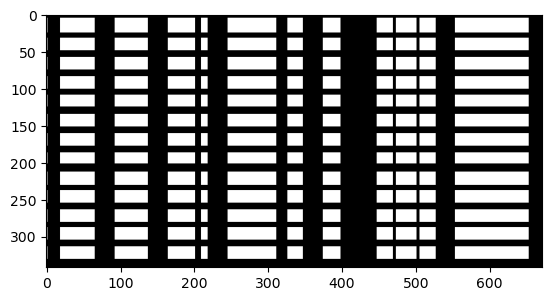

In [17]:
mask = (im * 255).astype(np.uint8)
mask_inv = cv2.bitwise_not(mask)
plt.imshow(mask_inv, cmap='gray')

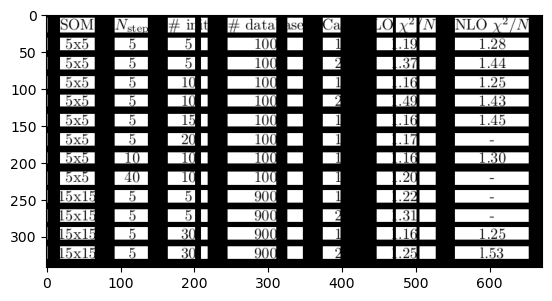

In [18]:
img_np = (img * 255).numpy().transpose(1,2,0).astype(np.uint8)
res = cv2.bitwise_and(img_np, img_np, mask=mask_inv)
plt.imshow(res)

In [19]:
img_np.dtype, mask.dtype

(dtype('uint8'), dtype('uint8'))

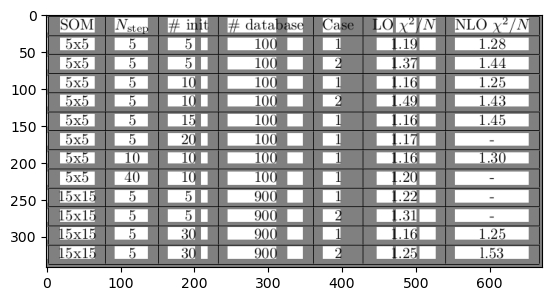

In [20]:
mask_inv_rgb = cv2.cvtColor(mask_inv, cv2.COLOR_GRAY2RGB)
res2 = cv2.addWeighted(img_np, 0.5, res, 0.5, 0)
plt.imshow(res2)